# **Recommended system final project MovieLens 100K**



you can follow Table of contents

# Downloads datasets and Imports




## Download from kaggle

In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c recsys-runi-2025

 90% 57.0M/63.6M [00:01<00:00, 58.6MB/s]
100% 63.6M/63.6M [00:01<00:00, 60.3MB/s]


In [7]:
!unzip recsys-runi-2025.zip

Archive:  recsys-runi-2025.zip
  inflating: movies.csv              
  inflating: ratings_submission.csv  
  inflating: tags.csv                
  inflating: train.csv               


In [8]:
! pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [9]:
! pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [10]:
! pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505162 sha256=3520553f4cd4f8cde99e7de6ba8ef980a6b94a9390ee24a7b19674806866dec9
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## Imports

In [11]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import Normalizer , scale
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from surprise import Reader, Dataset, accuracy, KNNBasic, SVD, SVDpp, NMF
from surprise.model_selection import GridSearchCV, cross_validate

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils import plot_model

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud

%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

## W-RMSE

In [12]:

def weighted_rmse(predictions, actuals, total_ratings):
    """
    Compute the Weighted Root Mean Squared Error (W-RMSE).

    Parameters:
    - predictions: numpy array of predicted ratings (y^i)
    - actuals: numpy array of actual ratings (y_i)
    - total_ratings: numpy array of total ratings for each movie

    Returns:
    - w_rmse: Weighted Root Mean Squared Error
    """
    # Compute weights: w_i = 1 / sqrt(total_ratings)
    weights = 1 / np.sqrt(total_ratings)

    # Ensure weights are valid
    weights[np.isinf(weights)] = 0  # Handle division by zero for movies with no ratings

    # Compute weighted squared errors
    weighted_squared_errors = weights * (predictions - actuals) ** 2

    # Compute W-RMSE
    w_rmse = np.sqrt(np.sum(weighted_squared_errors) / np.sum(weights))
    return w_rmse


## Extract Datasets

In [13]:

movies_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/movies.csv")
ratings_submission = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/ratings_submission.csv")
tags = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/tags.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/train.csv")

In [14]:
df_t = train.copy()
df_m = movies_df.copy()

# Exploring the Dataset

## Train

In [15]:
train.head()

,user_id,movie_id,rating
0,0,0,NaN
1,0,8,NaN
2,0,11,NaN
3,0,25,NaN
4,0,31,2.0


The "train" dataframe has 3 columns.

* **userId:** Every user is represented by an unique Id.
* **movieId:** Every movie is represented by an uniue Id.
* **rating:** Represents the rating given by the user to the corresponding movie.

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18321319 entries, 0 to 18321318
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   movie_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 419.3 MB


In [17]:
train.shape

(18321319, 3)

In [18]:
train.isna().sum()

,0
user_id,0
movie_id,0
rating,11017969


In [19]:
train = train.dropna()

In [20]:
train.shape

(7303350, 3)

In [21]:
train.isna().sum()

,0
user_id,0
movie_id,0
rating,0


In [22]:
train.describe()

,user_id,movie_id,rating
count,7.303350e+06,7.303350e+06,7.303350e+06
mean,1.002845e+05,2.090139e+04,3.607693e+00
std,5.790387e+04,3.918753e+04,1.023953e+00
min,0.000000e+00,0.000000e+00,5.000000e-01
25%,5.017200e+04,1.173000e+03,3.000000e+00
50%,1.003360e+05,2.710000e+03,4.000000e+00
75%,1.502420e+05,8.354000e+03,4.500000e+00
max,2.009580e+05,2.706880e+05,5.000000e+00


**Insights:**

* **Data Size:** The dataset contains over 7.3 million ratings, indicating a large and potentially rich dataset for analysis.

* **Average Rating:** The average rating given by users is approximately 3.61.

* **Rating Distribution:** The standard deviation of ratings is 1.02, indicating a moderate spread around the average rating. The minimum rating is 0.5, and the maximum rating is 5.0.



## Movies

In [23]:
movies_df.head()

,movie_id,title,genres
0,11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,8,Jumanji (1995),Adventure|Children|Fantasy
2,9,Grumpier Old Men (1995),Comedy|Romance
3,15,Father of the Bride Part II (1995),Comedy
4,12,Heat (1995),Action|Crime|Thriller


The "movies" dataframe has 3 columns.

* **movieId:** Every movie is represented by an unique Id.
* **title:** Movie which is represented by the corresponding movieId.
* **genres:** Represents category of the movie.

In [24]:
movies_df.shape

(2000, 3)

In [25]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  2000 non-null   int64 
 1   title     2000 non-null   object
 2   genres    2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [26]:
movies_df.isna().sum()

,0
movie_id,0
title,0
genres,0


## Combining the Movies and Train DataFrame

In [27]:
df_combined = pd.merge(train, movies_df, on = 'movie_id')

In [28]:
df_combined.head()

,user_id,movie_id,rating,title,genres
0,0,31,2.0,Get Shorty (1995),Comedy|Crime|Thriller
1,0,37,4.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,0,38,3.0,Mortal Kombat (1995),Action|Adventure|Fantasy
3,0,58,3.5,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
4,0,160,3.5,Hackers (1995),Action|Adventure|Crime|Thriller


In [29]:
df_combined.shape

(7303350, 5)

# Visualizations on the Dataset

## Genres

In [30]:
genres = {}

def find_genres():
    for genre in movies_df['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1

find_genres()

In [31]:
genres

{'Adventure': 465,
 'Animation': 143,
 'Children': 174,
 'Comedy': 729,
 'Fantasy': 228,
 'Romance': 365,
 'Action': 622,
 'Crime': 314,
 'Thriller': 555,
 'Drama': 879,
 'Horror': 148,
 'Mystery': 170,
 'Sci-Fi': 362,
 'War': 91,
 'Musical': 78,
 'IMAX': 93,
 'Documentary': 12,
 'Western': 40,
 'Film-Noir': 21,
 '(no genres listed)': 1}

In [32]:
genres['None'] = genres.pop('(no genres listed)')

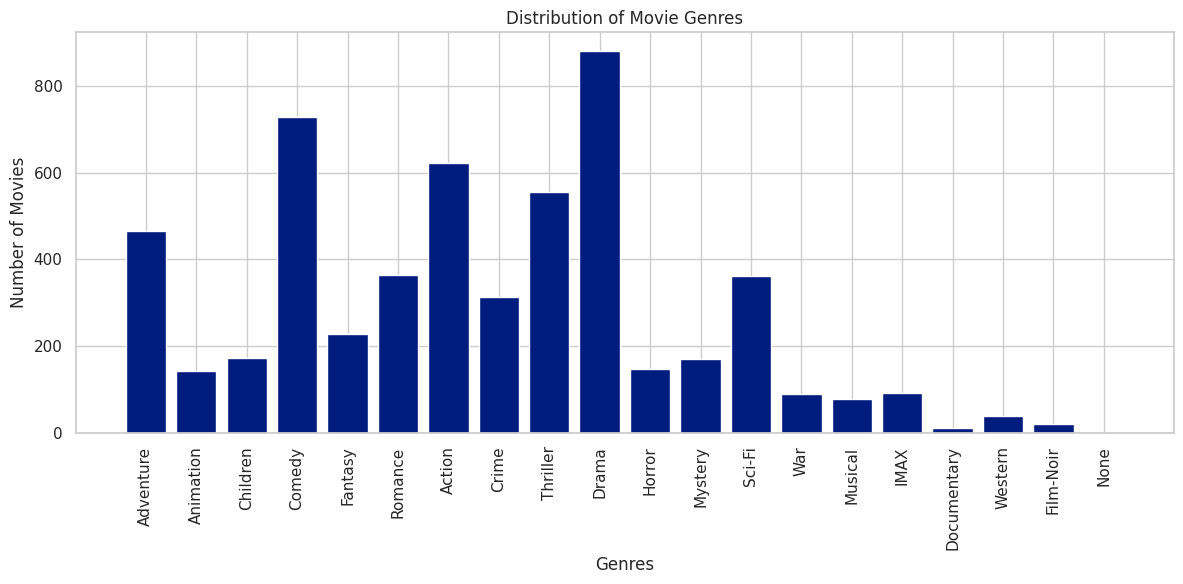

In [33]:
plt.figure(figsize=(12, 6))
plt.bar(genres.keys(), genres.values())
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movie Genres")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

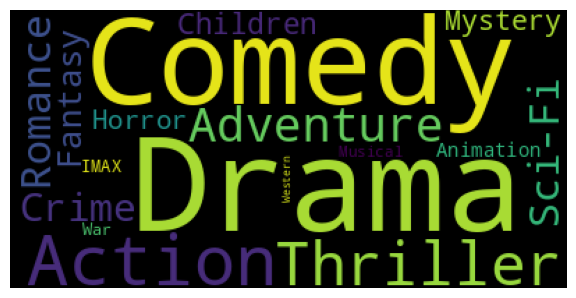

In [34]:
wordcloud = WordCloud(width=400, height=200, background_color = 'black', min_font_size=7).generate_from_frequencies(genres)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Heavily Rated Movies

In [35]:
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.024726,25884
Pulp Fiction (1994),4.196908,25423
"Shawshank Redemption, The (1994)",4.391781,25245
"Matrix, The (1999)",4.151609,24916
"Silence of the Lambs, The (1991)",4.130094,23533
Star Wars: Episode IV - A New Hope (1977),4.107460,22627
Fight Club (1999),4.219062,20622
Star Wars: Episode V - The Empire Strikes Back (1980),4.139578,20347
Jurassic Park (1993),3.697238,20237


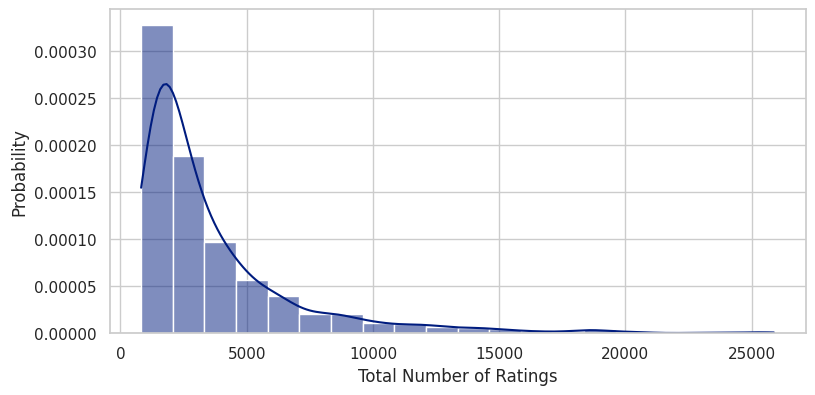

In [36]:
plt.figure(figsize=(8,4))
sns.histplot(df_n_ratings['total ratings'], bins=20, kde=True, stat="density")
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

**Insights:**

The steep drop-off in ratings frequency indicates that most movies are only rated a small number of times. This is consistent with the "long-tail" phenomenon commonly observed in recommendation systems, where a few popular items dominate user attention.

Also movies might be niche or not heavily marketed, contributing to fewer ratings.

## Highly Rated Movies

In [37]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
"Shawshank Redemption, The (1994)",4.391781,25245
"Godfather, The (1972)",4.313805,17812
Parasite (2019),4.276551,3305
12 Angry Men (1957),4.267692,6472
"Usual Suspects, The (1995)",4.258074,18423
"Godfather: Part II, The (1974)",4.256446,12178
Seven Samurai (Shichinin no samurai) (1954),4.240428,5093
Fight Club (1999),4.219062,20622
Rear Window (1954),4.219059,7482


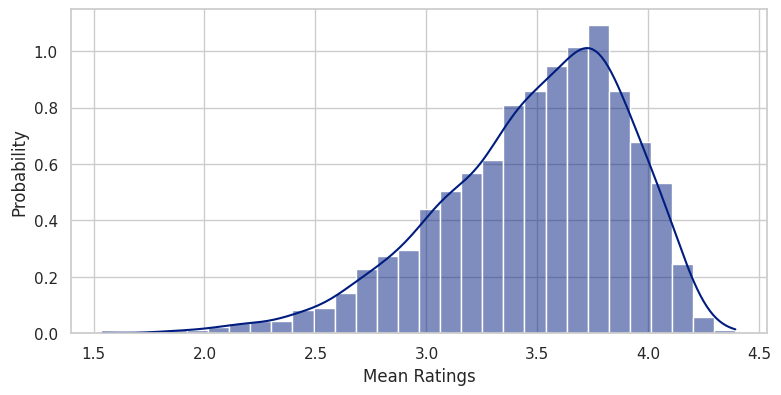

In [38]:
plt.figure(figsize=(8,4))
sns.histplot(df_n_ratings['mean ratings'], bins=30, kde=True, stat="density")
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

## Mean Ratings vs Total Number of Ratings

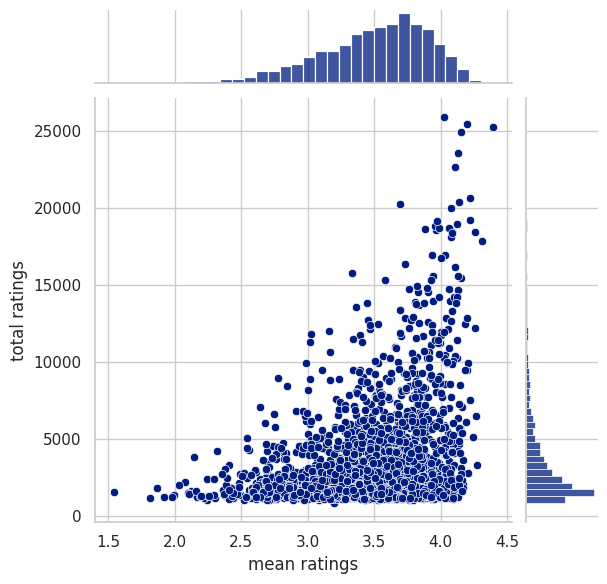

In [39]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

Here, every Data Point represents a distinct Movie, with y-coordinate representing the total no of users which has rated that movie and x-coordinate representing the mean of all the ratings of the corresponding users.

Items with high total ratings are likely to dominate the recommendations due to their visibility and higher user interactions.

The mean ratings are roughly centered around 3.5-4.0, with fewer items falling below ~3.0. This indicates a general tendency toward higher average ratings

**more eda!**

# Collaborative Filtering (CF)

## Model Based Collaborative Filtering

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( train[['user_id', 'movie_id', 'rating']], reader = reader )

### K-Nearest Neighbours (KNN)

In [ ]:
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=10, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)
trainset = data.build_full_trainset()
algo.fit(trainset)

In [ ]:
n_neighbours = [10, 20, 30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

### Singular Value Decomposition (SVD)

In [ ]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

In [ ]:
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

In [ ]:
best_params = gs.best_params['rmse']
best_svd = SVD(**best_params)  # Create a new SVD object with the best parameters

# Fit the best SVD model to the full trainset
trainset = data.build_full_trainset()
best_svd.fit(trainset)

### Singular Value Decomposition (SVD++). best score, Using Weighted RMSE

In [ ]:
# algo = SVDpp()
# cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

In [ ]:
# param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.1, 0.01], 'reg_all' : [0.06, 0.04]}

# gs = GridSearchCV(algo_class=SVDpp, measures=['RMSE'], param_grid=param_grid)
# gs.fit(data)

# print('\n###############')
# # Best RMSE score
# print('Best Score :', gs.best_score['rmse'])

# # Combination of parameters that gave the best RMSE score
# print('Best Parameters :', gs.best_params['rmse'])
# print('###############')

In [ ]:
reader = Reader(rating_scale=(0.5, 5))  # Define rating scale
data = Dataset.load_from_df(train[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)

In [ ]:
model = SVDpp()
model.fit(trainset)

In [ ]:
predictions = model.test(testset)

In [ ]:
from surprise import accuracy

rmse = accuracy.rmse(predictions)

RMSE: 0.7894


In [ ]:
predicted_ratings = [pred.est for pred in predictions]
actual_ratings = [pred.r_ui for pred in predictions]

In [ ]:
total_ratings_per_movie = train.groupby('movie_id')['rating'].count().to_dict()

# Create an array of total ratings corresponding to the movies in the test set
total_ratings_testset = [total_ratings_per_movie.get(pred.iid, 0) for pred in predictions]

In [ ]:
w_rmse = weighted_rmse(np.array(predicted_ratings), np.array(actual_ratings), np.array(total_ratings_testset))
print("Weighted RMSE:", w_rmse)

Weighted RMSE: 0.7951433655248333


In [ ]:
user_ids = [s.split("_")[0] for s in ratings_submission['id']]
movie_ids = [s.split("_")[1] for s in ratings_submission['id']]

predictions = []

for user_id, movie_id in zip(user_ids, movie_ids):
    prediction = model.predict(int(user_id), int(movie_id))
    predictions.append(prediction.est)

ratings_submission['prediction'] = predictions

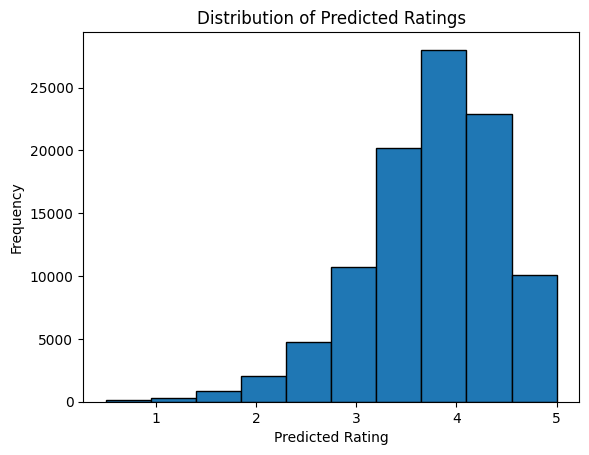

In [ ]:
plt.hist(ratings_submission['prediction'], bins=10, edgecolor='black')  # Adjust bins as needed

# Customize the plot
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Ratings')

# Show the plot
plt.show()

In [ ]:
ratings_submission.to_csv('submission.csv', index=False)

In [ ]:
s = pd.read_csv("submission.csv")
s

,id,prediction
0,0_1188,3.540932
1,5_7163,3.319795
2,8_460,4.340944
3,9_3705,3.810298
4,11_2650,3.510215
...,...,...
99995,200938_859,3.171373
99996,200953_69751,3.896254
99997,200954_70276,3.889584
99998,200955_33800,1.389567


In [ ]:
! kaggle competitions submit -c recsys-runi-2025 -f submission.csv -m "Collaborative Filtering svd++"

### Non-Negative Matrix Factorization (NMF)

In [ ]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

# Matrix Factorization using Deep Learning

## Splitting Data into Train and Validation Set

In [ ]:
X = train[['user_id', 'movie_id']]
Y = train['rating']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,)

## Embedding

In [ ]:
# The number of latent factors for the embedding
n_latent_factors = 50

# no of users and movies
n_users = len(train['user_id'].unique())
n_movies = len(train['movie_id'].unique())

## Architecture 1

In [ ]:
# Model Architecture

# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)

## Visualizing the Model Architecture

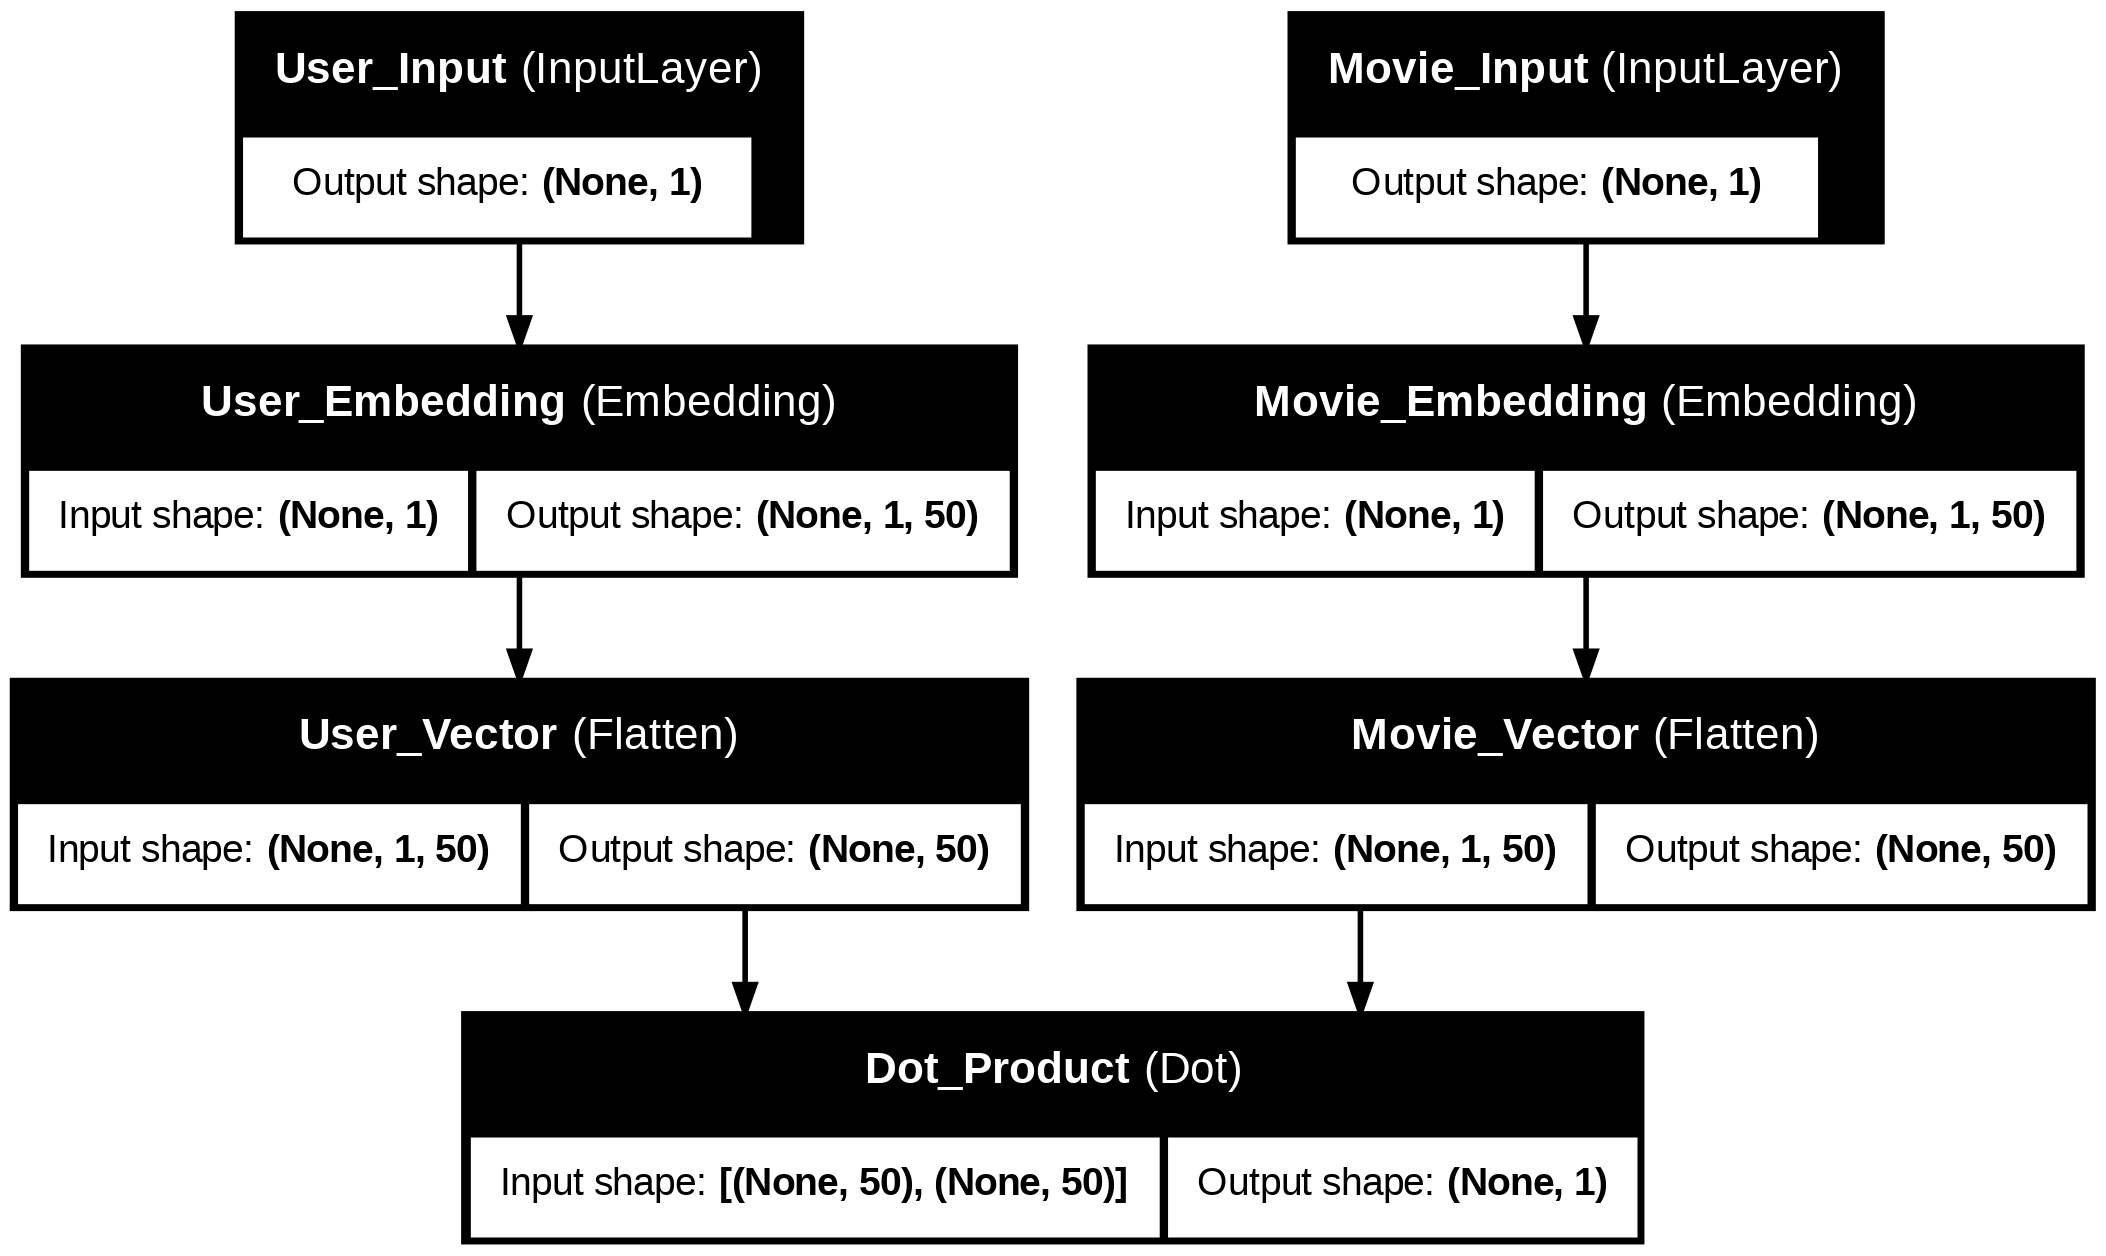

In [ ]:

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
display(Image(filename='model.png'))

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Embedding            │ (None, 1, 50)          │      5,000,000 │ User_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Embedding           │ (None, 1, 50)          │        100,000 │ Movie_Input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Vector (Flatten)     │ (None, 50)             │              0 │ User_Embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Vector (Flatten)    │ (None, 50)             │              0 │ Movie_Embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dot_Product (Dot)         │ (None, 1)              │              0 │ User_Vector[0][0],     │
│                           │                        │                │ Movie_Vector[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,100,000 (19.45 MB)

 Trainable params: 5,100,000 (19.45 MB)

 Non-trainable params: 0 (0.00 B)

## Fitting the Model

In [ ]:
optimizer = Adam(learning_rate = 0.0005)
model.compile(loss='mean_squared_error', optimizer = optimizer)

batch_size = 128
epochs = 20

In [ ]:
x_train['user_id'] = x_train['user_id'].apply(lambda x: x % n_users)
x_test['user_id'] = x_test['user_id'].apply(lambda x: x % n_users)
x_train['movie_id'] = x_train['movie_id'].apply(lambda x: x % n_movies)
x_test['movie_id'] = x_test['movie_id'].apply(lambda x: x % n_movies)

# Fit the model
history = model.fit(
    x=[x_train['user_id'], x_train['movie_id']],  # Input user and movie IDs
    y=y_train,                                    # Target ratings
    batch_size=batch_size,                        # Specify batch size
    epochs=epochs,                                # Number of epochs
    verbose=2,                                    # Verbose mode
    validation_data=([x_test['user_id'], x_test['movie_id']], y_test)  # Validation data
)

Epoch 1/4
45646/45646 - 101s - 2ms/step - loss: 2.5578 - val_loss: 0.8962
Epoch 2/4
45646/45646 - 97s - 2ms/step - loss: 0.8664 - val_loss: 0.8492
Epoch 3/4
45646/45646 - 97s - 2ms/step - loss: 0.8122 - val_loss: 0.8163
Epoch 4/4
45646/45646 - 97s - 2ms/step - loss: 0.7538 - val_loss: 0.7944


After observing that my model began to overfit around the 4th epoch, I decided to stop the training. The output shows that starting from the 5th epoch, the validation loss increases while the training loss continues to decrease. <br><br>
You can see my previous results here: <br>
Epoch 1/20<br>
45646/45646 - 101s - 2ms/step - loss: 2.5584 - val_loss: 0.9066<br>
Epoch 2/20<br>
45646/45646 - 99s - 2ms/step - loss: 0.8760 - val_loss: 0.8575<br>
Epoch 3/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.8166 - val_loss: 0.8202<br>
Epoch 4/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.7552 - val_loss: 0.7965<br>
Epoch 5/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.6860 - val_loss: 0.7933<br>
Epoch 6/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.6207 - val_loss: 0.8103<br>
Epoch 7/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.5686 - val_loss: 0.8357<br>
Epoch 8/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.5306 - val_loss: 0.8628<br>
Epoch 9/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.5037 - val_loss: 0.8874<br>
Epoch 10/20<br>
45646/45646 - 97s - 2ms/step - loss: 0.4841 - val_loss: 0.9097<br>
Epoch 11/20<br>
45646/45646 - 98s - 2ms/step - loss: 0.4695 - val_loss: 0.9298<br>

## Plotting Validation Curves

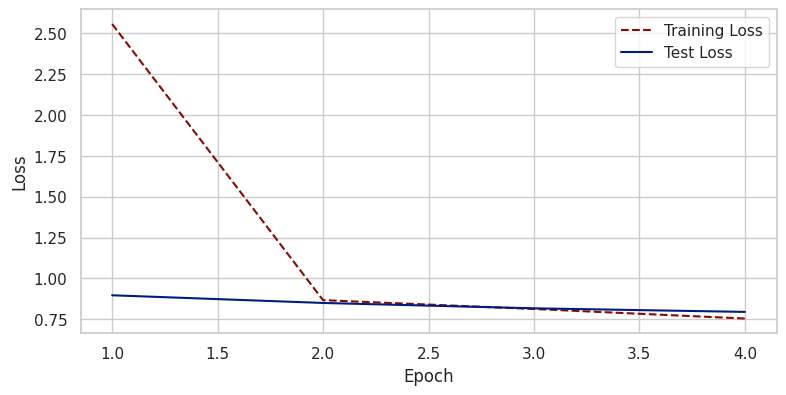

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Evaluating RMSE

In [ ]:
score = model.evaluate([x_test['user_id'], x_test['movie_id']], y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

45646/45646 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 0.7952

RMSE: 0.8913


## Architecture 1 prediction

In [ ]:
# Get the user_id and movie_id values from ratings_submission
user_ids = [int(s.split("_")[0]) for s in ratings_submission['id']]
movie_ids = [int(s.split("_")[1]) for s in ratings_submission['id']]

# Convert user_ids and movie_ids to DataFrames
user_ids_df = pd.DataFrame(user_ids, columns=['user_id'])
movie_ids_df = pd.DataFrame(movie_ids, columns=['movie_id'])

# Make prediction using the Keras model
predictions = model.predict([user_ids_df['user_id'], movie_ids_df['movie_id']])

# Flatten the predictions array if necessary
predictions = predictions.flatten()

# Assign the predictions to the 'prediction' column in ratings_submission
ratings_submission['prediction'] = predictions


ratings_submission['prediction']

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


0        3.674731
1        4.212278
2        4.437127
3        3.633282
4        3.520862
           ...   
99995   -0.107152
99996   -0.004705
99997   -0.004705
99998   -0.004705
99999    0.005598
Name: prediction, Length: 100000, dtype: float32

In [ ]:
ratings_submission['prediction'].max()

5.8084516525268555

In [ ]:
ratings_submission['prediction'].min()

-0.22727984189987183

In [ ]:
# Clip the predictions to the range of 1 to 4.5
ratings_submission['prediction'] = ratings_submission['prediction'].clip(lower=1, upper=4.5)

In [ ]:
ratings_submission['prediction'].max()

4.5

In [ ]:
ratings_submission['prediction'].min()

1.0

In [ ]:
ratings_submission['prediction'].mean()

2.4074352

we can see model is not performing well one of the reasons because the mean of its predictions significantly deviates from the mean of the actual data

## Architecture 2

In [ ]:
# Model Architecture


# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1,
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)



# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1,
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)




# Concatenate Product
merged_vectors = concatenate([user_vector, movie_vector], name='Concantenate')
dense_layer_1 = Dense(100, activation='relu')(merged_vectors)
# dense_layer_1 = Dropout(0.25) (dense_layer_1)
# batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
# dense_layer_2 = Dense(64, activation='relu')(merged_vectors)


result = Dense(1)(dense_layer_1)
model = Model([user_input, movie_input], result)

## Visualizing the Model Architecture

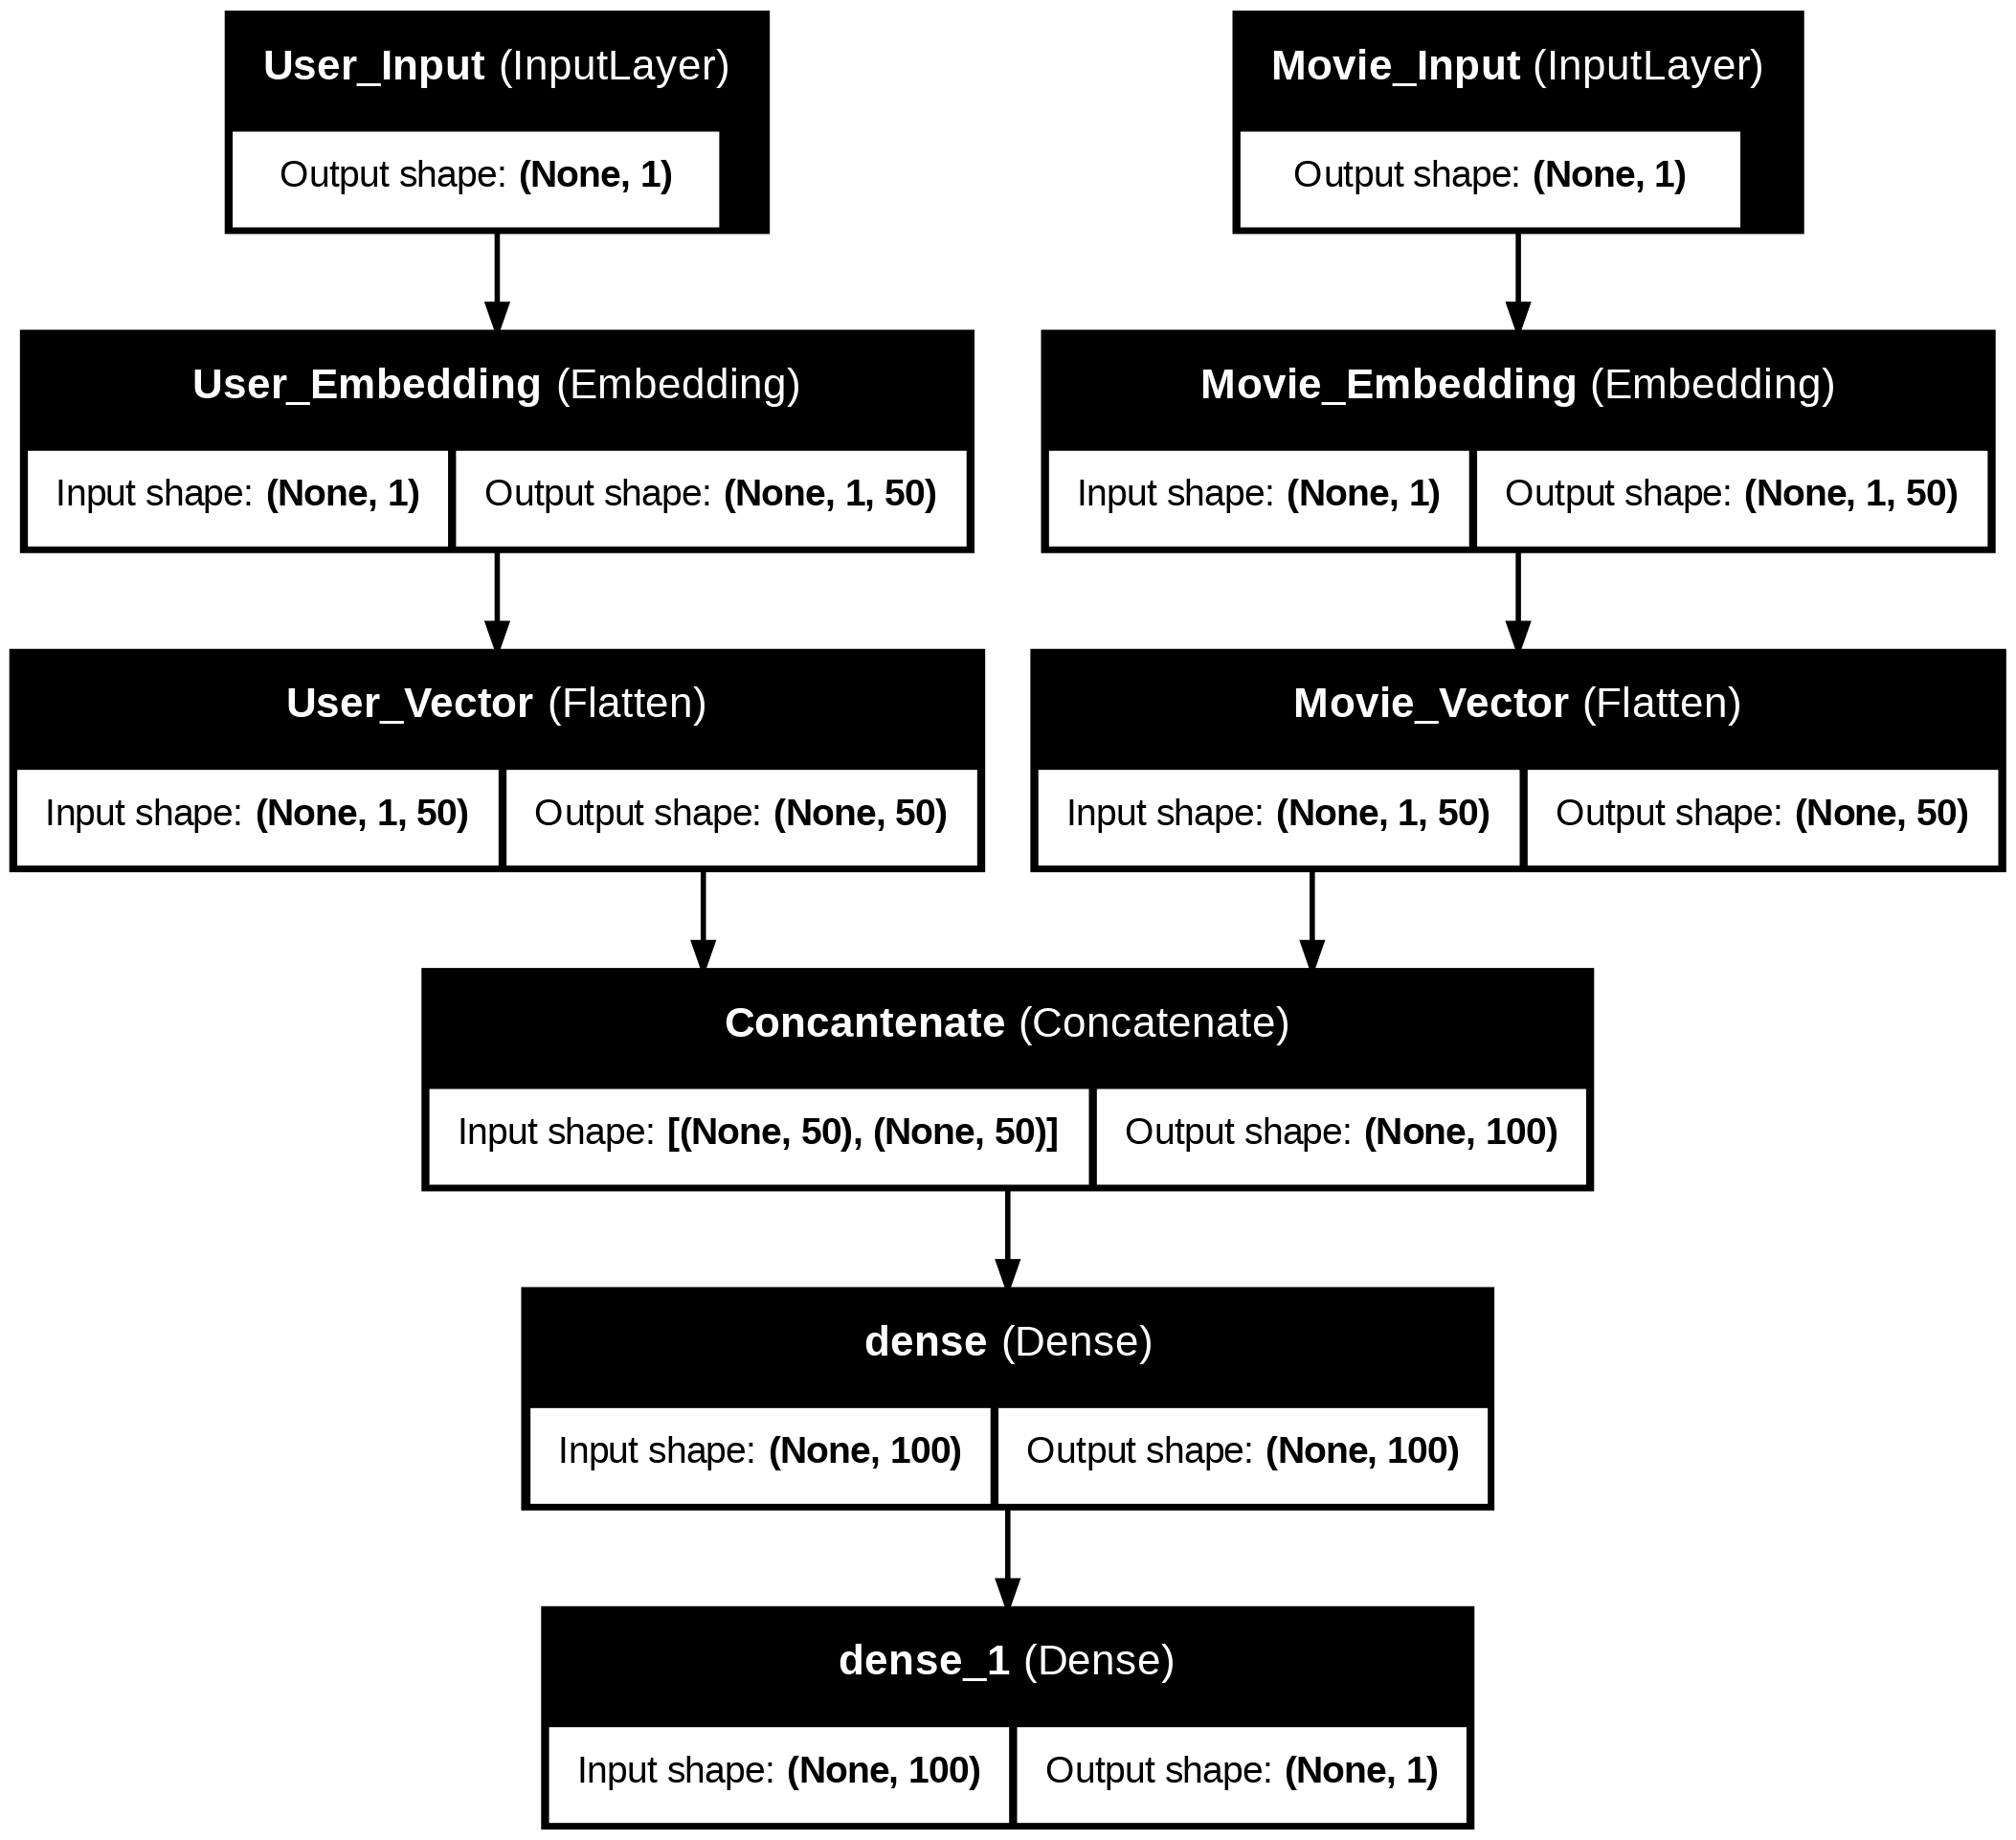

In [ ]:

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
display(Image(filename='model.png'))

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Embedding            │ (None, 1, 50)          │      5,000,000 │ User_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Embedding           │ (None, 1, 50)          │        100,000 │ Movie_Input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Vector (Flatten)     │ (None, 50)             │              0 │ User_Embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Vector (Flatten)    │ (None, 50)             │              0 │ Movie_Embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Concantenate              │ (None, 100)            │              0 │ User_Vector[0][0],     │
│ (Concatenate)             │                        │                │ Movie_Vector[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100)            │         10,100 │ Concantenate[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            101 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,110,201 (19.49 MB)

 Trainable params: 5,110,201 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

## Fitting the Model

In [ ]:
optimizer = Adam(learning_rate=0.0002)
model.compile(loss='mean_squared_error', optimizer=optimizer)

batch_size = 128
epochs = 9

In [ ]:
x_train['user_id'] = x_train['user_id'].apply(lambda x: x % n_users)
x_test['user_id'] = x_test['user_id'].apply(lambda x: x % n_users)
x_train['movie_id'] = x_train['movie_id'].apply(lambda x: x % n_movies)
x_test['movie_id'] = x_test['movie_id'].apply(lambda x: x % n_movies)

# Fit the model
history = model.fit(
    x=[x_train['user_id'], x_train['movie_id']],  # Input user and movie IDs
    y=y_train,                                    # Target ratings
    batch_size=batch_size,                        # Specify batch size
    epochs=epochs,                                # Number of epochs
    verbose=2,                                    # Verbose mode
    validation_data=([x_test['user_id'], x_test['movie_id']], y_test)  # Validation data
)

Epoch 1/9
45646/45646 - 106s - 2ms/step - loss: 0.8961 - val_loss: 0.7985
Epoch 2/9
45646/45646 - 103s - 2ms/step - loss: 0.7810 - val_loss: 0.7744
Epoch 3/9
45646/45646 - 103s - 2ms/step - loss: 0.7565 - val_loss: 0.7651
Epoch 4/9
45646/45646 - 103s - 2ms/step - loss: 0.7392 - val_loss: 0.7599
Epoch 5/9
45646/45646 - 103s - 2ms/step - loss: 0.7212 - val_loss: 0.7563
Epoch 6/9
45646/45646 - 103s - 2ms/step - loss: 0.7040 - val_loss: 0.7569
Epoch 7/9
45646/45646 - 103s - 2ms/step - loss: 0.6866 - val_loss: 0.7589
Epoch 8/9
45646/45646 - 103s - 2ms/step - loss: 0.6675 - val_loss: 0.7646
Epoch 9/9
45646/45646 - 103s - 2ms/step - loss: 0.6475 - val_loss: 0.7691


After observing that my model began to overfit around the 9th epoch, I decided to stop the training. The output shows that starting from the 10th epoch, the validation loss increases while the training loss continues to decrease. <br><br>
You can see my previous results here: <br>
Epoch 1/20<br>
45646/45646 - 107s - 2ms/step - loss: 0.8914 - val_loss: 0.7988<br>
Epoch 2/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.7751 - val_loss: 0.7769<br>
Epoch 3/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.7529 - val_loss: 0.7687<br>
Epoch 4/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.7367 - val_loss: 0.7638<br>
Epoch 5/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.7181 - val_loss: 0.7610<br>
Epoch 6/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.7008 - val_loss: 0.7609<br>
Epoch 7/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.6840 - val_loss: 0.7640<br>
Epoch 8/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.6655 - val_loss: 0.7680<br>
Epoch 9/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.6458 - val_loss: 0.7743<br>
Epoch 10/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.6259 - val_loss: 0.7823<br>
Epoch 11/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.6069 - val_loss: 0.7922<br>
Epoch 12/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.5894 - val_loss: 0.8014<br>
Epoch 13/20<br>
45646/45646 - 104s - 2ms/step - loss: 0.5735 - val_loss: 0.8134<br>
Epoch 14/20<br>

## Plotting Validation Curves

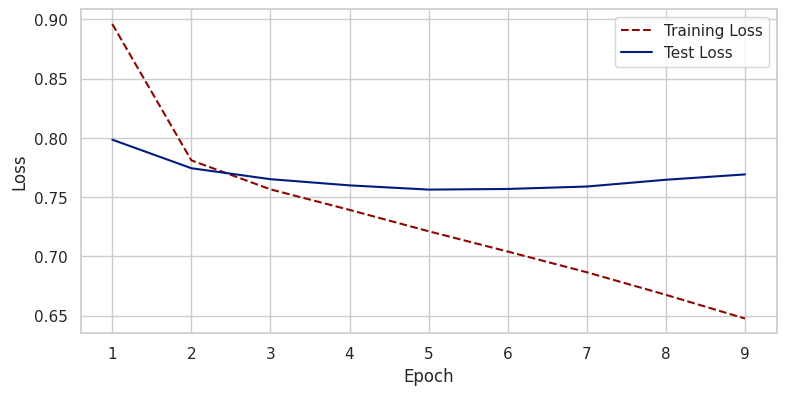

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

##  Evaluating RMSE

In [ ]:
score = model.evaluate([x_test['user_id'], x_test['movie_id']], y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

45646/45646 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 0.7681

RMSE: 0.8770


In [ ]:
# Get the user_id and movie_id values from ratings_submission
user_ids = [int(s.split("_")[0]) for s in ratings_submission['id']]
movie_ids = [int(s.split("_")[1]) for s in ratings_submission['id']]

# Convert user_ids and movie_ids to DataFrames
user_ids_df = pd.DataFrame(user_ids, columns=['user_id'])
movie_ids_df = pd.DataFrame(movie_ids, columns=['movie_id'])

# Make prediction using the Keras model
predictions = model.predict([user_ids_df['user_id'], movie_ids_df['movie_id']])

# Flatten the predictions array if necessary
predictions = predictions.flatten()

# Assign the predictions to the 'prediction' column in ratings_submission
ratings_submission['prediction'] = predictions


ratings_submission['prediction']

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


0        3.631208
1        4.351104
2        4.397984
3        4.131853
4        3.537171
           ...   
99995    2.735871
99996    3.748891
99997    3.748891
99998    3.748891
99999    3.588554
Name: prediction, Length: 100000, dtype: float32

In [ ]:
ratings_submission['prediction'].max()

5.274493217468262

In [ ]:
ratings_submission['prediction'].min()

0.3504303991794586

In [ ]:
ratings_submission['prediction'].mean()
ratings_submission['prediction'] = ratings_submission['prediction'].clip(lower=1, upper=4.5)

In [ ]:
ratings_submission['prediction'].max()

4.5

In [ ]:
ratings_submission['prediction'].mean()

3.698357

we can see model is performing well one of the reasons because the mean of its predictions same as the mean of the actual data

## Pros and Cons SVD VS Deep Models

**SVD is Better:**
* When you have a small dataset like MovieLens 100k.
* When interpretability and simplicity are priorities.
* For purely collaborative filtering tasks.

**Deep Models are Better:**
* For large-scale datasets with millions of interactions.
* When you have rich side information.
* If you aim to uncover complex non-linear patterns or use hybrid approaches.

**When to Use Each?**<br>
**SVD**<br>
* **Dataset Size:** Small to medium datasets.
* **Data Sparsity:** Performs well even with sparse interaction matrices.
* **Cold-Start Problem:** Struggles without extra data or interactions for new users/items.
* **Complex Patterns:** Captures only linear relationships between users and items.
* **Ease of Implementation:** Simple and quick to implement.
* **Computation Cost:** Low computational cost and efficient.

**Deep Models**
* **Dataset Size:** Best for large datasets (>1M interactions).
* **Data Sparsity:** Requires careful architecture design to handle sparse data.
* **Cold-Start Problem:** Can handle cold-start issues by incorporating side features.
* **Complex Patterns:** Excels at capturing complex non-linear user-item relationships.
* **Ease of Implementation:** Requires expertise in architecture design and hyperparameter tuning.
* **Computation Cost:** High, requiring more resources and longer training times.

# Prediction and Submission

In [ ]:

# Get the user_id and movie_id values from ratings_submission
user_ids = [s.split("_")[0] for s in ratings_submission['id']]
movie_ids = [s.split("_")[1] for s in ratings_submission['id']]

# Create a list to store the predictions
predictions = []

# Iterate through user_id and movie_id pairs and predict ratings
for user_id, movie_id in zip(user_ids, movie_ids):
    prediction = algo.predict(int(user_id), int(movie_id))  # Use algo instead of model
    predictions.append(prediction.est)

# Assign the predictions to the 'prediction' column in ratings_submission
ratings_submission['prediction'] = predictions
ratings_submission['prediction']

,prediction
0,3.442743
1,3.586964
2,4.551348
3,3.375492
4,3.579470
...,...
99995,3.186610
99996,3.898303
99997,3.933388
99998,3.022023


In [ ]:
ratings_submission.to_csv('submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c recsys-runi-2025 -f submission.csv -m "submission"

100% 2.83M/2.83M [00:03<00:00, 939kB/s] 
Successfully submitted to RecSys Competition 2025 (RUNI)

# NCF

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import spacy
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer

def process_metadata(movies_df, tags_df, max_tags=1000):
    """
    Process movie metadata with enhanced tag processing that considers semantic meaning.

    Parameters:
    - movies_df: DataFrame with movie_id, title, genres
    - tags_df: DataFrame with user_id, movie_id, tag
    - max_tags: Maximum number of most frequent tags to keep

    Returns:
    - genre_features: Dictionary mapping movie_id to genre features
    - tag_features: Dictionary mapping movie_id to semantic tag features
    - num_genre_features: Number of genre features
    - num_tag_features: Number of tag features
    """
    # PART 1: Genre Processing
    # Extract all unique genres from the dataset by splitting the genre strings
    all_genres = set()
    for genres in movies_df['genres'].str.split('|'):
        all_genres.update(genres)
    genres_list = sorted(list(all_genres))

    # Create one-hot encoded features for genres
    genre_features = {}
    for _, row in movies_df.iterrows():
        movie_genres = row['genres'].split('|')
        features = np.zeros(len(genres_list))
        for genre in movie_genres:
            if genre in genres_list:
                features[genres_list.index(genre)] = 1
        genre_features[row['movie_id']] = features

    # PART 2: Enhanced Tag Processing with Semantics
    # Load spaCy model for word embeddings
    nlp = spacy.load('en_core_web_md')

    # Clean and normalize tags
    cleaned_tags_df = tags_df.copy()
    cleaned_tags_df['tag'] = (cleaned_tags_df['tag']
                             .fillna('')  # Fill NaN values with empty string
                             .str.lower()
                             # Remove special characters but keep spaces
                             .str.replace(r'[^a-z\s]', ' ', regex=True)
                             # Remove extra whitespace
                             .str.replace(r'\s+', ' ', regex=True)
                             .str.strip())

    # Create tag embeddings for semantic processing
    tag_embeddings = {}
    unique_tags = set(cleaned_tags_df['tag'].unique())

    # Calculate embeddings for each unique tag
    for tag in unique_tags:
        doc = nlp(tag)
        if doc.has_vector:
            tag_embeddings[tag] = doc.vector

    # Group similar tags using semantic similarity
    semantic_clusters = defaultdict(list)
    processed_tags = set()

    # Create clusters of similar tags based on cosine similarity
    for tag1 in tag_embeddings:
        if tag1 not in processed_tags:
            cluster = [tag1]
            for tag2 in tag_embeddings:
                if tag2 != tag1 and tag2 not in processed_tags:
                    # Calculate similarity between tag vectors
                    similarity = 1 - cosine(tag_embeddings[tag1], tag_embeddings[tag2])
                    if similarity > 0.8:  # Threshold for considering tags similar
                        cluster.append(tag2)
                        processed_tags.add(tag2)

            # Use the shortest tag in cluster as the representative name
            cluster_name = min(cluster, key=len)
            semantic_clusters[cluster_name].extend(cluster)
            processed_tags.add(tag1)

    # Create a mapping from any tag to its cluster name
    tag_to_cluster = {}
    for cluster_name, similar_tags in semantic_clusters.items():
        for tag in similar_tags:
            tag_to_cluster[tag] = cluster_name

    # Aggregate tags by movie using semantic clusters
    movie_tag_counts = defaultdict(lambda: defaultdict(int))
    for _, row in cleaned_tags_df.iterrows():
        movie_id = row['movie_id']
        tag = row['tag']

        # Use cluster name if tag is in a cluster, otherwise use the original tag
        cluster_name = tag_to_cluster.get(tag, tag)
        movie_tag_counts[movie_id][cluster_name] += 1

    # Convert aggregated tag counts to TF-IDF features
    # Create text representation for each movie using semantic clusters
    movie_tag_texts = {
        movie_id: ' '.join(f"{tag} " * count
                          for tag, count in tags.items())
        for movie_id, tags in movie_tag_counts.items()
    }

    # Create TF-IDF vectorizer with semantic features
    vectorizer = TfidfVectorizer(
        max_features=max_tags,
        stop_words='english',
        min_df=2,  # Minimum document frequency
        max_df=0.8  # Maximum document frequency (removes too common tags)
    )

    # Fit vectorizer on all movie tag texts
    all_tag_texts = list(movie_tag_texts.values())
    vectorizer.fit(all_tag_texts)

    # Transform movie tags into TF-IDF features
    tag_features = {}
    for movie_id, tags_text in movie_tag_texts.items():
        features = vectorizer.transform([tags_text]).toarray()[0]
        tag_features[movie_id] = features

    # Handle movies without tags by assigning zero vectors
    zero_tag_features = np.zeros(max_tags)
    for movie_id in movies_df['movie_id']:
        if movie_id not in tag_features:
            tag_features[movie_id] = zero_tag_features

    return genre_features, tag_features, len(genres_list), max_tags

In [ ]:
class EnhancedMovieLensDataset(Dataset):
    """
    Dataset class that includes both ratings and metadata features.
    """
    def __init__(self, user_ids, movie_ids, ratings,
                 genre_features, tag_features):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.movie_ids = torch.tensor(movie_ids, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

        # Determine the number of features
        num_genre_features = len(next(iter(genre_features.values())))
        num_tag_features = len(next(iter(tag_features.values())))

        # Convert metadata features to tensors, handling missing movie_ids
        self.genre_features = torch.tensor(
            np.array([genre_features.get(mid, np.zeros(num_genre_features)) for mid in movie_ids]),
            dtype=torch.float32
        )
        self.tag_features = torch.tensor(
            np.array([tag_features.get(mid, np.zeros(num_tag_features)) for mid in movie_ids]),
            dtype=torch.float32
        )

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            self.user_ids[idx],
            self.movie_ids[idx],
            self.genre_features[idx],
            self.tag_features[idx],
            self.ratings[idx]
        )

In [ ]:
class EnhancedNeuMF(torch.nn.Module):
    """
    Enhanced Neural Matrix Factorization model that incorporates movie metadata.
    """
    def __init__(self, config):
        super(EnhancedNeuMF, self).__init__()
        self.config = config


        self.embedding_user_mlp = torch.nn.Embedding(
            num_embeddings=config['num_users'],
            embedding_dim=config['latent_dim_mlp']
        )
        self.embedding_item_mlp = torch.nn.Embedding(
            num_embeddings=config['num_items'],
            embedding_dim=config['latent_dim_mlp']
        )
        self.embedding_user_mf = torch.nn.Embedding(
            num_embeddings=config['num_users'],
            embedding_dim=config['latent_dim_mf']
        )
        self.embedding_item_mf_id = torch.nn.Embedding(
            num_embeddings=config['num_items'],
            embedding_dim=config['latent_dim_mf']
        )

        # Metadata processing layers
        self.genre_layer = torch.nn.Linear(
            config['num_genre_features'],
            config['metadata_dim']
        )
        self.tag_layer = torch.nn.Linear(
            config['num_tag_features'],
            config['metadata_dim']
        )

        # Calculate input size for first FC layer
        self.mlp_input_dim = (
            config['latent_dim_mlp'] * 2 +  # User and item MLP embeddings
            config['metadata_dim'] * 2       # Processed genre and tag features
        )

        # Create FC layers with proper dimensions
        self.fc_layers = torch.nn.ModuleList()

        # Define layer sizes (input → hidden → output)
        layer_sizes = [self.mlp_input_dim] + config['layers']

        # Create fully connected layers
        for idx in range(len(layer_sizes) - 1):
            self.fc_layers.append(torch.nn.Linear(
                layer_sizes[idx],
                layer_sizes[idx + 1]
            ))

        # Output layer combines last FC layer output with MF vector
        self.affine_output = torch.nn.Linear(
            in_features=layer_sizes[-1] + config['latent_dim_mf'],
            out_features=1
        )

        # Metadata processing for MF component
        self.metadata_mf_processor = torch.nn.Sequential(
            torch.nn.Linear(
                config['num_genre_features'] + config['num_tag_features'],
                config['metadata_dim']
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                config['metadata_dim'],
                config['latent_dim_mf']
            )
        )

        # Gating mechanism to balance ID-based and metadata-based embeddings
        self.metadata_gate = torch.nn.Sequential(
            torch.nn.Linear(
                config['num_genre_features'] + config['num_tag_features'],
                1
            ),
            torch.nn.Sigmoid()
        )

        # Initialize weights if specified
        if config['weight_init_gaussian']:
            for module in self.modules():
                if isinstance(module, (torch.nn.Embedding, torch.nn.Linear)):
                    torch.nn.init.normal_(module.weight.data, 0.0, 0.01)


    def forward(self, user_indices, item_indices, genre_features, tag_features):
        # Process basic embeddings
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)

        # Create item embedding for MF part using both ID and metadata
        item_embedding_mf_id = self.embedding_item_mf_id(item_indices)

        # Combine genre and tag features
        metadata_features = torch.cat([genre_features, tag_features], dim=-1)

        # Process metadata into the MF latent space
        metadata_embedding_mf = self.metadata_mf_processor(metadata_features)

        # Calculate adaptive gate value based on metadata
        gate_value = self.metadata_gate(metadata_features)

        # Combine ID-based and metadata-based embeddings using the gate
        item_embedding_mf = (
            gate_value * item_embedding_mf_id +
            (1 - gate_value) * metadata_embedding_mf
        )

        # Process metadata
        genre_vector = torch.nn.ReLU()(self.genre_layer(genre_features))
        tag_vector = torch.nn.ReLU()(self.tag_layer(tag_features))



        # Combine all MLPs inputs
        mlp_vector = torch.cat([
            user_embedding_mlp,
            item_embedding_mlp,
            genre_vector,
            tag_vector
        ], dim=-1)

        # print shape of mlp_vector
        # print(f"shape of mlp_vector: {mlp_vector.shape}")

        # MF vector remains the same
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        # Process through FC layers
        for layer in self.fc_layers:
            mlp_vector = torch.nn.ReLU()(layer(mlp_vector))

        # Combine and predict
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        rating = self.affine_output(vector)

        return rating

In [ ]:
class WeightedMSELoss(torch.nn.Module):
    """
    Weighted Mean Squared Error Loss where weights are calculated based on
    movie rating counts.
    """
    def __init__(self, movie_rating_counts):
        super(WeightedMSELoss, self).__init__()
        # Calculate weights for each movie
        weights = 1.0 / np.sqrt(movie_rating_counts)
        self.weights = torch.tensor(weights, dtype=torch.float32)

    def forward(self, predictions, targets, movie_indices):
        # Get weights for current batch
        batch_weights = self.weights[movie_indices].to(predictions.device)
        # Calculate weighted MSE
        squared_errors = (predictions.squeeze() - targets) ** 2
        weighted_errors = squared_errors * batch_weights
        return weighted_errors.mean()

In [ ]:
config = {
    'num_users': None,  # Will be set after data processing
    'num_items': None,  # Will be set after data processing
    'num_genre_features': None,  # Will be set after metadata processing
    'num_tag_features': None,  # Will be set after metadata processing
    'latent_dim_mf': 64,
    'latent_dim_mlp': 64,
    'metadata_dim': 32,
    'layers': [128, 64, 32],
    'weight_init_gaussian': True,
    'learning_rate': 5e-4,
    'batch_size': 512,
    'num_epochs': 10,
    'l2_regularization': 2e-4,  # Added L2 regularization
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [ ]:
def prepare_data(train_df, movies_df, tags_df, val_size=0.15, test_size=0.05):
    """
    Prepares the data for training by:
    1. Filtering out implicit feedback (null ratings)
    2. Creating consistent user and movie ID mappings
    3. Splitting data into train/validation/test sets
    4. Processing metadata (genres and tags)

    Parameters:
    - train_df: DataFrame with user_id, movie_id, rating columns
    - movies_df: DataFrame with movie_id, title, genres columns
    - tags_df: DataFrame with user_id, movie_id, tag columns
    - val_size: Proportion of data to use for validation
    - test_size: Proportion of data to use for testing

    Returns:
    - Tuple containing:
        - (train_df, val_df, test_df): Split DataFrames
        - (user_to_idx, movie_to_idx): ID mapping dictionaries
        - (genre_features, tag_features): Processed metadata features
        - (num_genres, num_tags): Feature dimensions
    """
    # Make a copy of the dataframe to avoid the warning
    train_df = train_df.copy()

    # Step 1: Filter for explicit feedback only
    df = train_df.dropna(subset=['rating'])

    # Step 2: Create consistent ID mappings
    # Get all unique IDs from both ratings and metadata
    user_ids = sorted(df['user_id'].unique())
    movie_ids = sorted(pd.concat([
        df['movie_id'],
        movies_df['movie_id']
    ]).unique())

    # Create mapping dictionaries
    user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(movie_ids)}

    # Step 3: Convert IDs to indices in the ratings DataFrame
    df['user_idx'] = df['user_id'].map(user_to_idx)
    df['movie_idx'] = df['movie_id'].map(movie_to_idx)

    # Step 4: Process metadata
    # First, make sure movies_df uses the same movie indices
    movies_df = movies_df.copy()
    movies_df['movie_idx'] = movies_df['movie_id'].map(movie_to_idx)

    # Process genres and tags
    genre_features, tag_features, num_genres, num_tags = process_metadata(
        movies_df,
        tags_df,
        max_tags=1000  # Parameter to control vocabulary size
    )

    # Convert metadata features to use movie indices
    genre_features_idx = {
        movie_to_idx[mid]: features
        for mid, features in genre_features.items()
        if mid in movie_to_idx
    }

    tag_features_idx = {
        movie_to_idx[mid]: features
        for mid, features in tag_features.items()
        if mid in movie_to_idx
    }

    # Step 5: Split the data
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=42,
        stratify=df['rating'].round()  # Stratify by rounded ratings
    )

    # Second split: separate validation set from training
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size/(1-test_size),
        random_state=42,
        stratify=train_val_df['rating'].round()
    )

    # Step 6: Calculate movie rating counts for weighted loss
    movie_rating_counts = df['movie_idx'].value_counts().sort_index()

    return (
        (train_df, val_df, test_df),
        (user_to_idx, movie_to_idx),
        (genre_features_idx, tag_features_idx),
        (num_genres, num_tags),
        movie_rating_counts
    )

In [ ]:
def plot_metrics(train_metrics, val_metrics):
    """
    Creates a visualization of training progress focusing on loss and W-RMSE metrics.
    This function helps us understand how our model is learning over time by showing:
    1. Training and validation loss trends
    2. Validation W-RMSE trend

    Parameters:
    - train_metrics: Dictionary containing training metrics (loss)
    - val_metrics: Dictionary containing validation metrics (loss and w_rmse)
    """
    # Create a figure with two subplots arranged horizontally
    plt.figure(figsize=(15, 6))

    # First subplot: Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_metrics['loss'], label='Training Loss', color='blue')
    plt.plot(val_metrics['loss'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Second subplot: W-RMSE curve
    plt.subplot(1, 2, 2)
    plt.plot(val_metrics['w_rmse'], label='Validation W-RMSE', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('W-RMSE')
    plt.title('Validation Weighted RMSE')
    plt.legend()
    plt.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Save the plot for future reference
    plt.savefig('training_metrics.png')
    plt.close()

In [ ]:
def train_model(train_loader, val_loader, model, optimizer, criterion, config,
                save_dir='models', model_prefix='neuMF'):
    """
    Trains the model focusing on W-RMSE optimization and saves the best performing version.

    Parameters:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - model: The neural network model to train
    - optimizer: The optimizer for training
    - criterion: The loss function (weighted MSE)
    - config: Dictionary containing training parameters
    - save_dir: Directory to save model checkpoints
    - model_prefix: Prefix for saved model files

    Returns:
    - best_model_path: Path to the best performing model
    - best_w_rmse: Best validation W-RMSE achieved
    """
    # Create directory for saving models if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Initialize tracking variables
    best_w_rmse = float('inf')
    best_model_path = None
    plateau_counter = 0
    min_w_rmse_change = 0.0001  # Minimum improvement threshold

    # Initialize metrics dictionaries
    train_metrics = {'loss': []}
    val_metrics = {'loss': [], 'w_rmse': []}

    # Main training loop
    for epoch in range(config['num_epochs']):
        # Training phase
        model.train()
        train_loss = 0

        for batch_data in train_loader:
            # Unpack the batch data
            user_ids, movie_ids, genre_features, tag_features, ratings = [
                x.to(config['device']) for x in batch_data
            ]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(user_ids, movie_ids, genre_features, tag_features)

            # Calculate loss
            loss = criterion(predictions, ratings, movie_ids)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        all_predictions = []
        all_actuals = []
        all_movie_ids = []

        with torch.no_grad():
            for batch_data in val_loader:
                # Unpack the batch data
                user_ids, movie_ids, genre_features, tag_features, ratings = [
                    x.to(config['device']) for x in batch_data
                ]

                # Forward pass
                predictions = model(user_ids, movie_ids, genre_features, tag_features)

                # Calculate loss
                loss = criterion(predictions, ratings, movie_ids)
                val_loss += loss.item()

                # Collect predictions for W-RMSE calculation
                all_predictions.extend(predictions.squeeze().cpu().numpy())
                all_actuals.extend(ratings.cpu().numpy())
                all_movie_ids.extend(movie_ids.cpu().numpy())

        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        current_w_rmse = calculate_w_rmse(
            np.array(all_predictions),
            np.array(all_actuals),
            np.array(all_movie_ids)
        )

        # Store metrics
        train_metrics['loss'].append(avg_train_loss)
        val_metrics['loss'].append(avg_val_loss)
        val_metrics['w_rmse'].append(current_w_rmse)

        # Print progress with focus on W-RMSE
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'W-RMSE: {current_w_rmse:.6f}')

        # Check for W-RMSE improvement
        if current_w_rmse < best_w_rmse - min_w_rmse_change:
            # Remove previous best model if it exists
            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)

            # Save new best model
            best_w_rmse = current_w_rmse
            best_model_path = os.path.join(
                save_dir,
                f'{model_prefix}_wrmse{current_w_rmse:.6f}.pth'
            )

            # Save complete model information
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'w_rmse': current_w_rmse,
                'config': config
            }, best_model_path)

            plateau_counter = 0
            print(f'New best W-RMSE: {best_w_rmse:.6f}')
        else:
            plateau_counter += 1
            print(f'No improvement for {plateau_counter} epochs')

        # Early stopping based on W-RMSE plateau
        if plateau_counter >= config.get('early_stopping_patience', 5):
            print(f'Early stopping triggered after {epoch+1} epochs')
            print(f'Best W-RMSE achieved: {best_w_rmse:.6f}')
            break

    # Plot only relevant metrics
    plot_metrics(train_metrics, val_metrics)

    return best_model_path, best_w_rmse

In [ ]:
def calculate_w_rmse(predictions, actuals, movie_ids):
    """
    Calculate the Weighted Root Mean Square Error.

    Parameters:
    - predictions: numpy array of predicted ratings
    - actuals: numpy array of actual ratings
    - movie_ids: numpy array of movie IDs corresponding to each prediction

    Returns:
    - w_rmse: Weighted Root Mean Square Error
    """
    # Calculate movie rating counts
    movie_counts = np.bincount(movie_ids)

    # Calculate weights for each prediction
    weights = 1 / np.sqrt(movie_counts[movie_ids])

    # Calculate weighted squared errors
    squared_errors = (predictions - actuals) ** 2
    weighted_squared_errors = squared_errors * weights

    # Calculate W-RMSE
    w_rmse = np.sqrt(np.mean(weighted_squared_errors))

    return w_rmse

def load_best_model(model_path, device='cuda'):
    """
    Load a saved model checkpoint.

    Parameters:
    - model_path: Path to the saved model checkpoint
    - device: Device to load the model on

    Returns:
    - model: Loaded model
    - config: Model configuration
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Create model instance
    model = EnhancedNeuMF(checkpoint['config'])

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Move model to device
    model = model.to(device)

    return model, checkpoint['config']

In [ ]:
# Load data
movies = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/movies.csv")
ratings_submission = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/ratings_submission.csv")
tags = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/tags.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/train.csv")

# Process metadata
genre_features, tag_features, num_genres, num_tags = process_metadata(
    movies, tags, max_tags=1000
)

# Prepare all data
(train_df, val_df, test_df), \
(user_to_idx, movie_to_idx), \
(genre_features, tag_features), \
(num_genres, num_tags), \
movie_rating_counts = prepare_data(train, movies, tags)

# Update config
config.update({
    'num_users': len(user_to_idx),
    'num_items': len(movie_to_idx),
    'num_genre_features': num_genres,
    'num_tag_features': num_tags,
    'early_stopping_patience': 5
})

# Create datasets
train_dataset = EnhancedMovieLensDataset(
    train_df['user_idx'].values,
    train_df['movie_idx'].values,
    train_df['rating'].values,
    genre_features,
    tag_features
)

val_dataset = EnhancedMovieLensDataset(
    val_df['user_idx'].values,
    val_df['movie_idx'].values,
    val_df['rating'].values,
    genre_features,
    tag_features
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size']
)

# Initialize model and optimizer
model = EnhancedNeuMF(config).to(config['device'])
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['l2_regularization']
)

# Calculate movie rating counts for weighted loss
movie_rating_counts = train_df['movie_idx'].value_counts().sort_index()
criterion = WeightedMSELoss(movie_rating_counts)

# Train model
best_model, best_w_rmse = train_model(
    train_loader,
    val_loader,
    model,
    optimizer,
    criterion,
    config
)

# Download spaCy model
!python -m spacy download en_core_web_md

In [ ]:
config

In [ ]:
print(model)

# Explainable-AI XAI

## More EDA and Feature extraction

In [ ]:

movies = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/movies.csv")
ratings_submission = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/ratings_submission.csv")
tags = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/tags.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/recsys/train.csv")

In [ ]:
nan_train = train[train['rating'].isnull()]


In [ ]:
nan_train.shape

(11017969, 3)

In [ ]:
no_nan_train = train[train['rating'].notnull()]

In [ ]:
no_nan_train.shape

(7303350, 3)

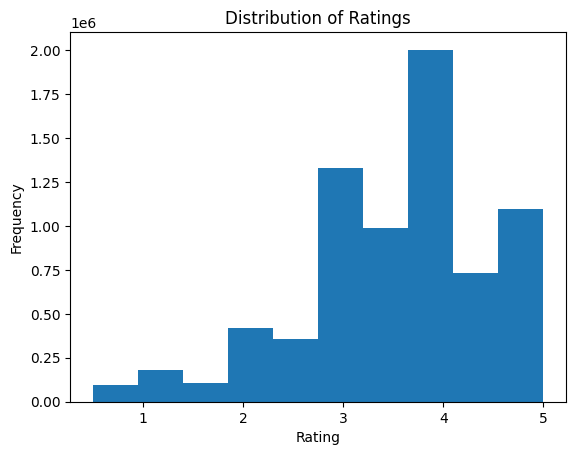

In [ ]:
plt.hist(train['rating'], bins=10) # Adjust bins as needed
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

In [ ]:
df_combined = pd.merge(train, movies, on = 'movie_id')

In [ ]:
df_combined.head()

,user_id,movie_id,rating,title,genres
0,0,31,2.0,Get Shorty (1995),Comedy|Crime|Thriller
1,0,37,4.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,0,38,3.0,Mortal Kombat (1995),Action|Adventure|Fantasy
3,0,58,3.5,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
4,0,160,3.5,Hackers (1995),Action|Adventure|Crime|Thriller


In [ ]:
genres = {}

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1

find_genres()

In [ ]:
genres

{'Adventure': 465,
 'Animation': 143,
 'Children': 174,
 'Comedy': 729,
 'Fantasy': 228,
 'Romance': 365,
 'Action': 622,
 'Crime': 314,
 'Thriller': 555,
 'Drama': 879,
 'Horror': 148,
 'Mystery': 170,
 'Sci-Fi': 362,
 'War': 91,
 'Musical': 78,
 'IMAX': 93,
 'Documentary': 12,
 'Western': 40,
 'Film-Noir': 21,
 '(no genres listed)': 1}

In [ ]:
genres.pop('(no genres listed)')

1

In [ ]:
genres

{'Adventure': 465,
 'Animation': 143,
 'Children': 174,
 'Comedy': 729,
 'Fantasy': 228,
 'Romance': 365,
 'Action': 622,
 'Crime': 314,
 'Thriller': 555,
 'Drama': 879,
 'Horror': 148,
 'Mystery': 170,
 'Sci-Fi': 362,
 'War': 91,
 'Musical': 78,
 'IMAX': 93,
 'Documentary': 12,
 'Western': 40,
 'Film-Noir': 21}

In [ ]:
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.024726,25884
Pulp Fiction (1994),4.196908,25423
"Shawshank Redemption, The (1994)",4.391781,25245
"Matrix, The (1999)",4.151609,24916
"Silence of the Lambs, The (1991)",4.130094,23533
Star Wars: Episode IV - A New Hope (1977),4.107460,22627
Fight Club (1999),4.219062,20622
Star Wars: Episode V - The Empire Strikes Back (1980),4.139578,20347
Jurassic Park (1993),3.697238,20237


In [ ]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
"Shawshank Redemption, The (1994)",4.391781,25245
"Godfather, The (1972)",4.313805,17812
Parasite (2019),4.276551,3305
12 Angry Men (1957),4.267692,6472
"Usual Suspects, The (1995)",4.258074,18423
"Godfather: Part II, The (1974)",4.256446,12178
Seven Samurai (Shichinin no samurai) (1954),4.240428,5093
Fight Club (1999),4.219062,20622
Rear Window (1954),4.219059,7482


In [ ]:
train['id'] = train['user_id'].astype(str) + '_' + train['movie_id'].astype(str)

In [ ]:
train

,user_id,movie_id,rating,id
4,0,31,2.0,0_31
5,0,37,4.0,0_37
6,0,38,3.0,0_38
11,0,58,3.5,0_58
17,0,160,3.5,0_160
...,...,...,...,...
18321310,200958,59321,4.5,200958_59321
18321312,200958,72001,4.5,200958_72001
18321313,200958,73004,5.0,200958_73004
18321316,200958,78479,3.0,200958_78479


In [ ]:
all_genres = []
for index in movies.index:
  all_genres.extend(movies.loc[index, "genres"].split("|"))

# 2. Get genres that appear in more than 20 movies (replace 20 with your threshold)
from collections import Counter
genre_counts = Counter(all_genres)
frequent_genres = [genre for genre, count in genre_counts.items() if count > 20]

# 3. Create one-hot encoding columns
for genre in frequent_genres:
  movies[genre] = movies['genres'].str.contains(genre).astype(int)

In [ ]:
movies = movies.drop('genres', axis=1)
movies

,movie_id,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,Crime,Thriller,Drama,Horror,Mystery,Sci-Fi,War,Musical,IMAX,Western,Film-Noir
0,11,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,Jumanji (1995),1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,Grumpier Old Men (1995),0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,15,Father of the Bride Part II (1995),0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,Heat (1995),0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,217459,Tenet (2020),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1996,225183,Soul (2020),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1997,254732,Dune (2021),1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
1998,262997,Spider-Man: No Way Home (2021),1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0


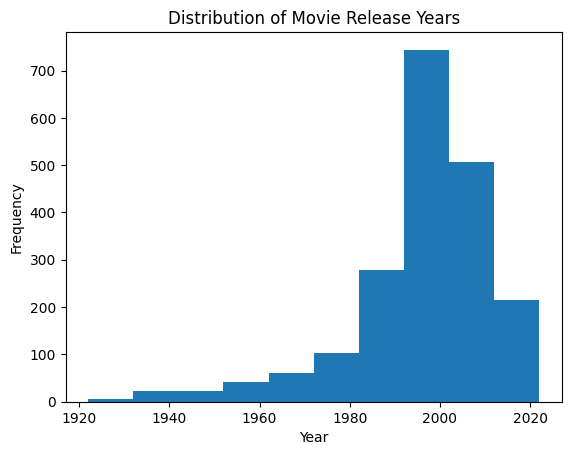

In [ ]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
plt.hist(movies['year'].dropna().astype(int), bins=10)  # Adjust bins as needed
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Release Years")
plt.show()

In [ ]:
movies['year'] = pd.to_numeric(movies['year'], errors='coerce').fillna(1900).astype(int)

In [ ]:
movies = movies.drop('title', axis=1)
movies

,movie_id,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,Crime,Thriller,Drama,Horror,Mystery,Sci-Fi,War,Musical,IMAX,Western,Film-Noir,year
0,11,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1,8,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
2,9,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1995
3,15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
4,12,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,217459,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2020
1996,225183,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2020
1997,254732,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,2021
1998,262997,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,2021


In [ ]:
combined_df = pd.merge(train, movies, on='movie_id', how='left')
combined_df.head()

,user_id,movie_id,rating,id,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Drama,Horror,Mystery,Sci-Fi,War,Musical,IMAX,Western,Film-Noir,year
0,0,31,2.0,0_31,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,0,37,4.0,0_37,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1995
2,0,38,3.0,0_38,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1995
3,0,58,3.5,0_58,0,1,1,0,0,1,...,1,0,0,0,0,1,0,0,0,1995
4,0,160,3.5,0_160,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [ ]:
tags.head()

,user_id,movie_id,tag
0,28,79586,misogyny
1,40,2164,music
2,40,2164,weird
3,48,7441,bullying
4,48,7441,clique


In [ ]:
tag_counts = tags.groupby('movie_id')['tag'].count().reset_index()
tag_counts.rename(columns={'tag': 'num_tags'}, inplace=True)
tags = pd.merge(tags, tag_counts, on='movie_id', how='left')

In [ ]:
tags

,user_id,movie_id,tag,num_tags
0,28,79586,misogyny,282
1,40,2164,music,842
2,40,2164,weird,842
3,48,7441,bullying,848
4,48,7441,clique,848
...,...,...,...,...
961661,162285,89460,Matt Damon,677
961662,162285,89764,Joel Edgerton,248
961663,162285,89764,Nick Nolte,248
961664,162285,89764,Tom Hardy,248


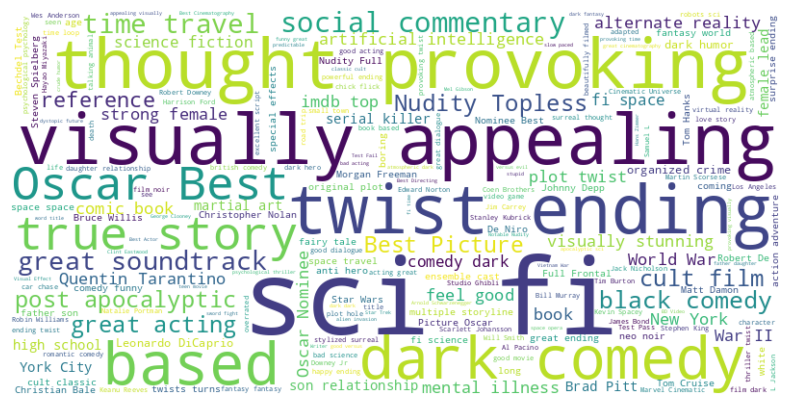

In [ ]:
text = ' '.join(tags['tag'].astype(str).tolist())

# Create and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

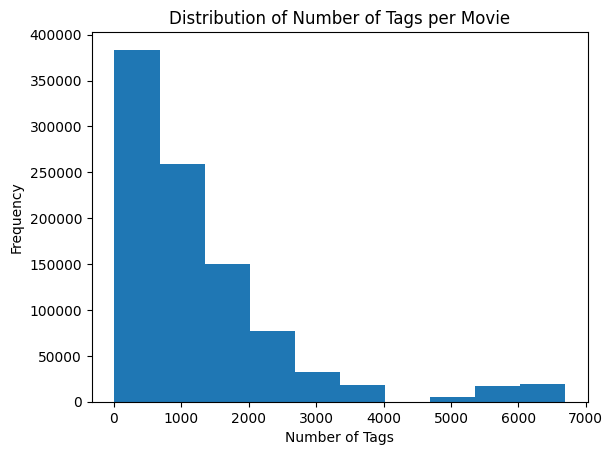

In [ ]:
plt.hist(tags['num_tags'], bins=10)  # Adjust bins as needed
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Tags per Movie")
plt.show()

In [ ]:
# Create a DataFrame with only movie_id and num_tags from tags
movie_tag_counts = tags[['movie_id', 'num_tags']].drop_duplicates()

# Merge with train, filling missing values with 0
combined_df = pd.merge(combined_df, movie_tag_counts, on='movie_id', how='left').fillna(0)

# Convert 'num_tags' to integers (if necessary)
combined_df['num_tags'] = combined_df['num_tags'].astype(int)

combined_df

,user_id,movie_id,rating,id,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,IMAX,Western,Film-Noir,year,num_tags
0,0,31,2.0,0_31,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1995,174
1,0,37,4.0,0_37,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1995,2604
2,0,38,3.0,0_38,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1995,92
3,0,58,3.5,0_58,0,1,1,0,0,1,...,0,0,0,0,1,0,0,0,1995,150
4,0,160,3.5,0_160,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1995,386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303345,200958,59321,4.5,200958_59321,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2008,1575
7303346,200958,72001,4.5,200958_72001,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2009,507
7303347,200958,73004,5.0,200958_73004,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2009,2617
7303348,200958,78479,3.0,200958_78479,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2010,493


## Create the model (RandomForestRegressor)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
X = combined_df.drop(['user_id', 'movie_id', 'rating','id'], axis=1)  # Remove unnecessary columns
y = combined_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)  # Adjust parameters as needed
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.9412692990915457


## Shap

In [ ]:
! pip install shap

In [ ]:
import shap
background_data = shap.sample(X_train, 100)

explainer = shap.TreeExplainer(rf_model, data=background_data)

shap_values = explainer.shap_values(X_test)

100%|===================| 1460596/1460670 [62:12<00:00]       

In [ ]:
shap_values_1 = explainer.shap_values(background_data)

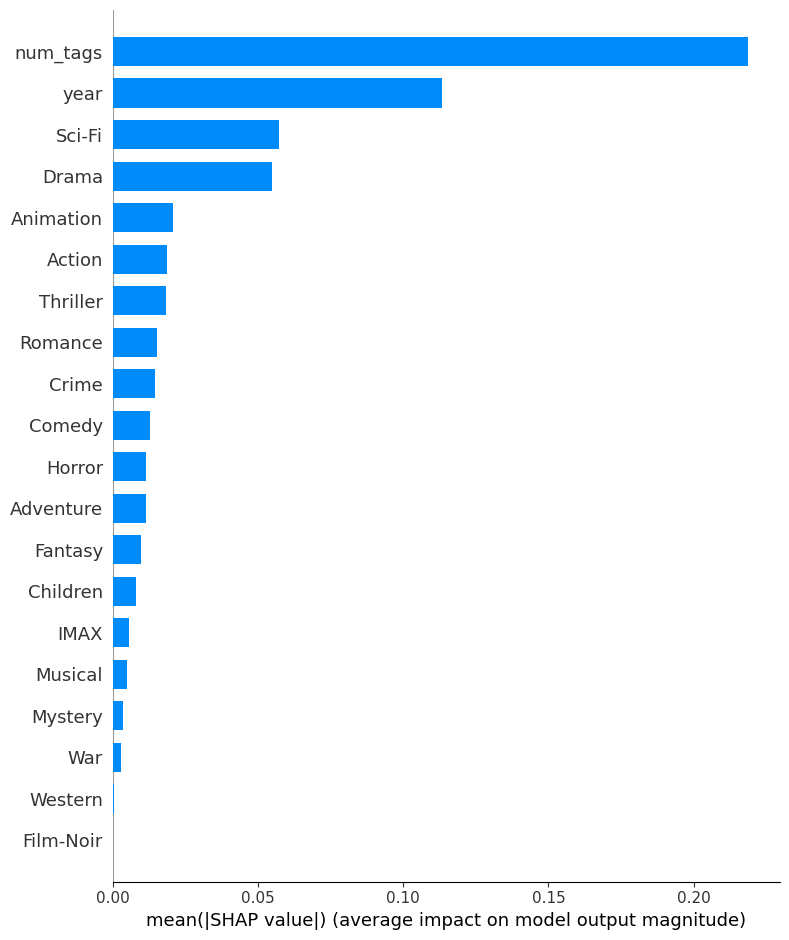

In [ ]:

shap.summary_plot(shap_values_1, background_data.values, plot_type="bar", feature_names = background_data.columns)

1. **Bars Represent Importance:** The horizontal bars indicate the mean absolute SHAP value for each feature. This measures how much each feature, on average, contributes to the model's predictions.

2. **Top Features:**
* num_tags: is the most important feature, meaning it has the largest impact on predictions.
* year follows in importance.
* Sci-Fi, Drama, and other genres are also contributing, though to a lesser extent.
This plot shows which features matter the most globally across the dataset.
3. **Low Features**: Features like Western, Film-Noir, and possibly War have very small SHAP values, meaning their contribution to the model is minimal.
Removing such features could simplify the model without significantly impacting performance.

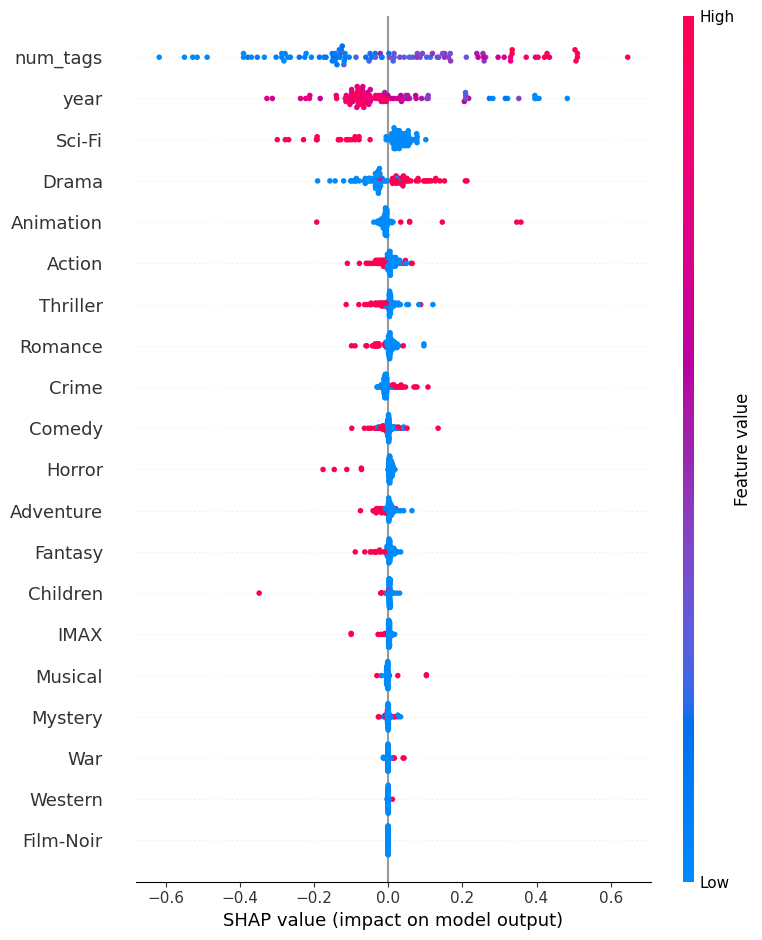

In [ ]:

shap.summary_plot(shap_values_1,background_data.values, feature_names = background_data.columns)

1. **Feature Contribution:**
* Each dot represents a single data point.
* The position of a dot on the x-axis shows the SHAP value, indicating whether the feature pushes the prediction higher (positive SHAP value) or lower (negative SHAP value).

2. Color Gradient:
The color represents the feature's value (red = high value, blue = low value).
For example, high num_tags (red dots) push predictions more positively, while low values (blue) push them negatively.

3. Spread:
Wider spreads (like for num_tags and year) mean the feature has varying impacts across the dataset.
Narrower spreads (like for less important features) suggest more consistent, lower impact.

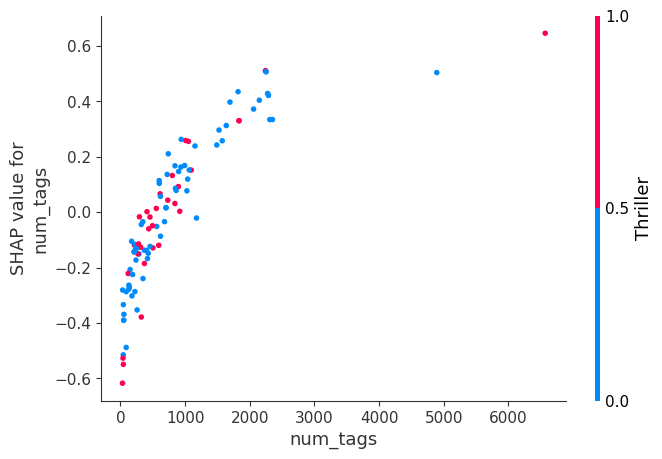

In [ ]:

shap.dependence_plot(19, shap_values_1, background_data.values, feature_names=background_data.columns)

* Positive Impact of num_tags: More tags generally increase the model's predictions.
* Interaction with Thriller: the dots (regardless of Thriller values) seem to follow a similar trend. Both high (Thriller = 1, red) and low (Thriller = 0, blue) values follow the same upward pattern with num_tags.
* Outliers: A few points with very high num_tags have extreme impacts and might need investigation.

In [ ]:
movies_df = pd.read_csv("/kaggle/input/recsys-runi-2025/movies.csv")

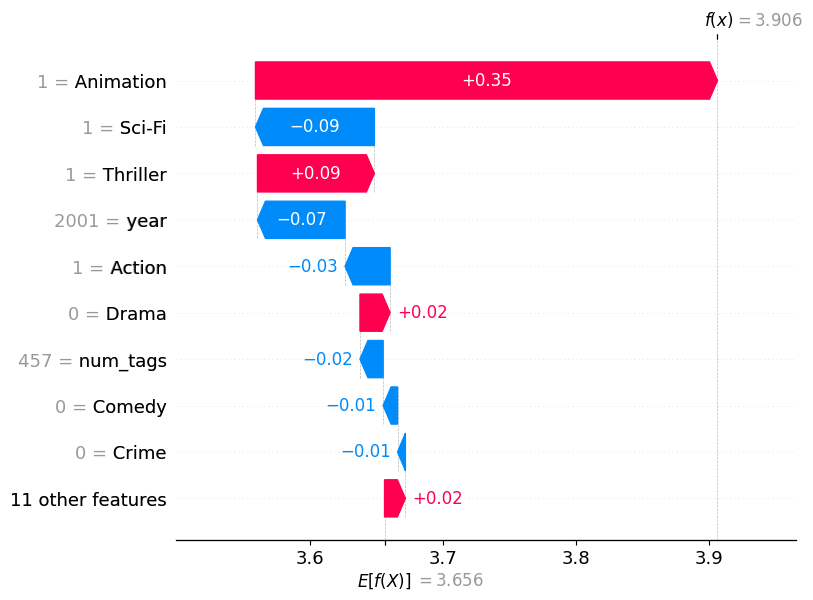

In [ ]:
row = 0
shap.waterfall_plot(shap.Explanation(values=shap_values_1[row],
                                     base_values=explainer.expected_value,
                                     data=background_data.iloc[row],
                                     feature_names=background_data.columns.tolist()))

* Features either push the prediction higher (positive SHAP values) or lower (negative SHAP values).

* Each step corresponds to a feature's impact.

This plot is helpful for explaining individual predictions by breaking down the contributions of each feature. It shows why the model made a specific prediction.

In [ ]:
background_data_index = background_data.index[row]
X_train_index = X_train.index[background_data_index]

movie_id = combined_df.loc[X_train_index, 'movie_id']

movie_title = movies_df[movies_df['movie_id'] == movie_id]['title'].iloc[0]

print(f"The movie is: {movie_title}")

The movie is: Ransom (1996)


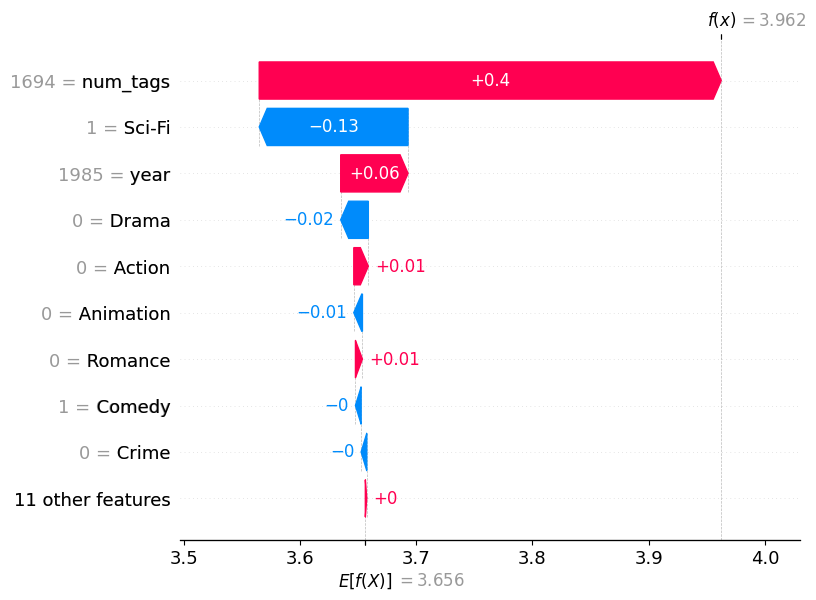

In [ ]:
row = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_1[row],
                                     base_values=explainer.expected_value,
                                     data=background_data.iloc[row],
                                     feature_names=background_data.columns.tolist()))

In [ ]:

background_data_index = background_data.index[row]
X_train_index = X_train.index[background_data_index]

movie_id = combined_df.loc[X_train_index, 'movie_id']

movie_title = movies_df[movies_df['movie_id'] == movie_id]['title'].iloc[0]

print(f"The movie is: {movie_title}")

The movie is: Midnight in the Garden of Good and Evil (1997)


**summarize**<br>
It would be beneficial to remove low-impact features (as shown by SHAP values) to simplify the model and improve interpretability. Additionally, introducing more implicit or engineered features—such as feature interactions. could improve performance